# Post-Processing (General)

#### Updated: May 17, 2023

#  

Post-processing pipeline after stage 2 of Alouette processing (OCR processing stage):

In [111]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns

In [112]:
rootDir = 'L:/DATA/Alouette_I/BATCH_II_Run2/'
processedDir = rootDir + '04_processed/'
resultDir = rootDir + '05_result/'
logDir = rootDir + '06_log/'

#  

#### Functions:

In [113]:
def construct_timestamp(df_in):
    
    df_in['time_quality'] = 0
    
    #To the nearest second (time quality 1)
    df_in['month_day'] = pd.to_datetime(df_in['day_of_year'], format='%j').dt.strftime('%m-%d')
    df_in['month'] = df_in['month_day'].str.split('-').str[0]
    df_in['day'] = df_in['month_day'].str.split('-').str[1]
    df_in['Timestamp'] = pd.to_datetime(df_in[['year', 'month', 'day', 'hour', 'minute', 'second']], format='%Y-%m-%d %H:%M:%S')
    df_in.loc[~df_in['Timestamp'].isnull(), 'time_quality'] = 1
    df_in_tq1 = df_in.loc[df_in['time_quality'] == 1]
    
    #To the nearest minute (time quality 2)
    df_in_not_tq1 = df_in.loc[df_in['time_quality'] != 1]
    df_in_not_tq1 = df_in_not_tq1.copy(deep=True)
    df_in_not_tq1['Timestamp'] = pd.to_datetime(df_in_not_tq1[['year', 'month', 'day', 'hour', 'minute']], format='%Y-%m-%d %H:%M:00')
    df_in_not_tq1.loc[~df_in_not_tq1['Timestamp'].isnull(), 'time_quality'] = 2
    df_in_tq2 = df_in_not_tq1.loc[df_in_not_tq1['time_quality'] == 2]
    
    #To the nearest hour (time quality 3)
    df_in_not_tq2 = df_in_not_tq1.loc[df_in_not_tq1['time_quality'] != 2]
    df_in_not_tq2 = df_in_not_tq2.copy(deep=True)
    df_in_not_tq2['Timestamp'] = pd.to_datetime(df_in_not_tq2[['year', 'month', 'day', 'hour']], format='%Y-%m-%d %H:00:00')
    df_in_not_tq2.loc[~df_in_not_tq2['Timestamp'].isnull(), 'time_quality'] = 3
    df_in_tq3 = df_in_not_tq2.loc[df_in_not_tq2['time_quality'] == 3]
    
    #To the nearest day (time quality 4)
    df_in_not_tq3 = df_in_not_tq2.loc[df_in_not_tq2['time_quality'] != 3]
    df_in_not_tq3 = df_in_not_tq3.copy(deep=True)
    df_in_not_tq3['Timestamp'] = pd.to_datetime(df_in_not_tq3[['year', 'month', 'day']], format='%Y-%m-%d 00:00:00')
    df_in_not_tq3.loc[~df_in_not_tq3['Timestamp'].isnull(), 'time_quality'] = 4
    df_in_tq4 = df_in_not_tq3.loc[df_in_not_tq3['time_quality'] == 4]
    
    df_in_not_tq4 = df_in_not_tq3.loc[df_in_not_tq3['time_quality'] != 4]
    df_in = pd.concat([df_in_tq1, df_in_tq2, df_in_tq3, df_in_tq4, df_in_not_tq4])
    
    return df_in

#  

#### Generate processed_inventory, concatenate stage 1 results - RUN BEFORE starting stage 2 processing (OCR processing stage):

Generate processed_inventory:

In [ ]:
df_inventory = pd.DataFrame()
for directory in os.listdir(processedDir):
    print(directory)
    for subdirectory in os.listdir(processedDir + directory):
        n_images = len(os.listdir(processedDir + directory + '/' + subdirectory))
        df_inventory_ = pd.DataFrame({
            'Directory': directory, 
            'Subdirectory': subdirectory,
            'images': n_images,
            'subdir_id': directory + '_' + subdirectory
        }, index=[0])
        df_inventory = pd.concat([df_inventory, df_inventory_], axis=0, ignore_index=True)

In [ ]:
print(len(df_inventory))
df_inventory.head()

In [ ]:
df_inventory.to_csv(logDir + 'image_inventory_processed.csv', index=False)

Concatenate stage 1 results:

In [ ]:
df_result = pd.DataFrame()
i = 0
for file in os.listdir(resultDir):
    if 'R' in file:
        directory = file
        for file2 in os.listdir(resultDir + directory + '/'):
            if 'result-' in file2:
                fn_parts = file2.split('_')
                subdirectory = fn_parts[1].replace('.csv', '')
                if i > 0:
                    if i % 100 == 0:
                        df_result = pd.read_csv(resultDir + 'result_stage1_raw.csv')
                        print(len(df_result))
                try:
                    df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                    n = len(df_load)
                except pd.errors.EmptyDataError:
                    n = 0
                    df_load = pd.DataFrame()
                df_result = pd.concat([df_result, df_load])
                i += 1
                if i % 100 == 0:
                    print('Now saving the ' + str(i) + 'th result...')
                    df_result.to_csv(resultDir + 'result_stage1_raw.csv', index=False)
df_result.to_csv(resultDir + 'result_stage1_raw.csv', index=False)

In [ ]:
df_result = pd.read_csv(resultDir + 'result_stage1_raw.csv')
print(len(df_result))
df_result.sample(10)

#  

#### Concatenate 'OCR pass' results - START HERE after stage 2 processeing (OCR processing stage):

In [114]:
df_result = pd.DataFrame()
i = 0
for file in os.listdir(resultDir):
    if 'R' in file:
        directory = file
        for file2 in os.listdir(resultDir + directory + '/'):
            if 'result_OCRpass' in file2:
                fn_parts = file2.split('_')
                subdirectory = fn_parts[2].replace('.csv', '')
                if i > 0:
                    if i % 100 == 0:
                        df_result = pd.read_csv(resultDir + 'result_stage2_raw.csv')
                        print(len(df_result))
                try:
                    df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                    n = len(df_load)
                except pd.errors.EmptyDataError:
                    n = 0
                df_result = pd.concat([df_result, df_load])
                i += 1
                if i % 100 == 0:
                    print('Now saving the ' + str(i) + 'th result...')
                    df_result.to_csv(resultDir + 'result_stage2_raw.csv', index=False)
df_result.to_csv(resultDir + 'result_stage2_raw.csv', index=False)

Now saving the 100th result...
28730


#  

#### Reduce columns:

In [115]:
df_result = pd.read_csv(resultDir + 'result_stage2_raw.csv')
print(len(df_result))
df_result.head()

42466


C:\Users\rnaidoo\AppData\Local\Temp\ipykernel_24036\658820558.py:1: DtypeWarning: Columns (38,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df_result = pd.read_csv(resultDir + 'result_raw.csv')


,fmin,max_depth,satellite_number,year,day_1,day_2,day_3,hour_1,hour_2,minute_1,...,filename,station_code,station_number,rotated_metadata,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR
0,1.500000,1376.744186,2.0,0.0,2.0,4.0,0.0,4.0,0.0,0.0,...,10.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.500000,1609.302326,2.0,1.0,0.0,0.0,0.0,4.0,3.0,6.0,...,100.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.552419,1260.465116,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,...,103.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.500000,1260.465116,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,...,104.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.500000,1260.465116,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,...,105.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
df_result['year_1'] = df_result['year']
df_result = df_result[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 
                       'station_number', 'station_number_1', 'station_number_2', 'year_1', 'day_1', 'day_2', 'day_3', 
                       'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'satellite_number', 
                       'station_number_OCR', 'year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR', 
                       'metadata_type', 'is_dot', 'func_name', 'details']] 
df_result.sample(10)

,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR,metadata_type,is_dot,func_name,details
7743,R014207813,5022,345.png,loss,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata_translation.determine_leftside_metada...,NaN
10539,R014207819,4785-69,98.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,image_segmentation.segment_images_in_subdir.se...,"height: 710,width: 1767"
2646,R014207808,4575-50,105.png,loss,1.604839,7383.333333,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,bottom,True,NaN,NaN
24773,R014207838,4513-43A,29.png,loss,1.568548,1306.250000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
17425,R014207830,3699-43A,210.png,loss,4.537037,2100.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
36360,R014207961,1060-A,20.png,dot,1.616935,1446.000000,16.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7854,R014207813,5022,344.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,image_segmentation.segment_images_in_subdir.se...,"height: 688,width: 3831"
8795,R014207817,4170-03A,161.png,loss,1.500000,916.326531,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
11891,R014207822,3461-19A-2,234.png,loss,1.500000,846.875000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
137,R014207711,25,307.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,image_segmentation.segment_images_in_subdir.se...,"height: 843,width: 1887"


#  

#### Split results into different metadata types (dot, num, num2):

In [117]:
df_result['processed_image_class'].unique()

array(['num', 'loss', 'outlier', 'num2', 'dot'], dtype=object)

In [118]:
df_num2 = df_result.loc[df_result['processed_image_class'] == 'num2']
print(len(df_num2))

6111


In [119]:
df_num = df_result.loc[df_result['processed_image_class'] == 'num']
print(len(df_num))

10150


In [120]:
df_dot = df_result.loc[df_result['processed_image_class'] == 'dot']
print(len(df_dot))

997


In [121]:
df_outlier = df_result.loc[df_result['processed_image_class'] == 'outlier']
print(len(df_outlier))

4792


In [122]:
df_loss = df_result.loc[df_result['processed_image_class'] == 'loss']
print(len(df_loss))

20416


In [123]:
len(df_num2) + len(df_num) + len(df_dot) + len(df_outlier) + len(df_loss)

42466

#### num2 - check timestamp components, construct timestamp:

In [124]:
df_num2[['year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR']].sample(10)

,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR
20964,68.0,087,16.0,14.0,22.0
23807,67.0,137,08,54,26
22389,65,170,15.0,05,59
24518,61,111,16,39,12
20920,68.0,086,1.0,34.0,28.0
26487,67.0,270,15.0,44,11
17083,67,289,02,00,45
26521,67.0,271,2.0,46,43
23668,61.0,135,11,17,28
9744,67,266.0,17,02,01


year:

<Axes: xlabel='year_OCR', ylabel='Count'>

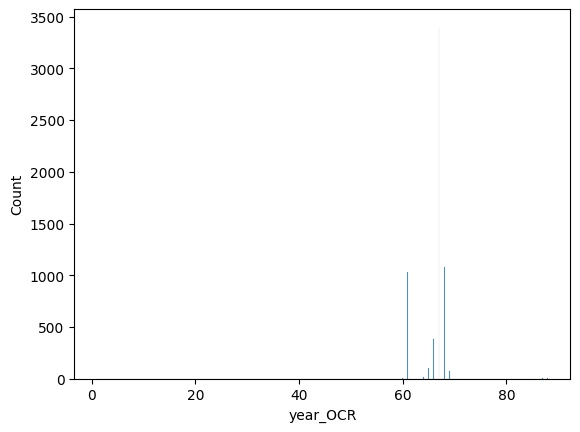

In [125]:
df_num2 = df_num2.copy(deep=True)
df_num2['year_OCR'] = df_num2['year_OCR'].astype('float')
sns.histplot(data=df_num2, x='year_OCR')

In [126]:
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x<62 else x)
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x>80 else x)

In [127]:
df_num2['year'] = df_num2['year_OCR'] + 1900
df_num2[['year', 'year_OCR']].sample(10)

,year,year_OCR
23751,1967.0,67.0
17143,1967.0,67.0
17047,1967.0,67.0
17276,1967.0,67.0
24373,NaN,NaN
18552,1967.0,67.0
19562,1967.0,67.0
9635,NaN,NaN
20355,1968.0,68.0
23668,NaN,NaN


day:

<Axes: xlabel='day_of_year_OCR', ylabel='Count'>

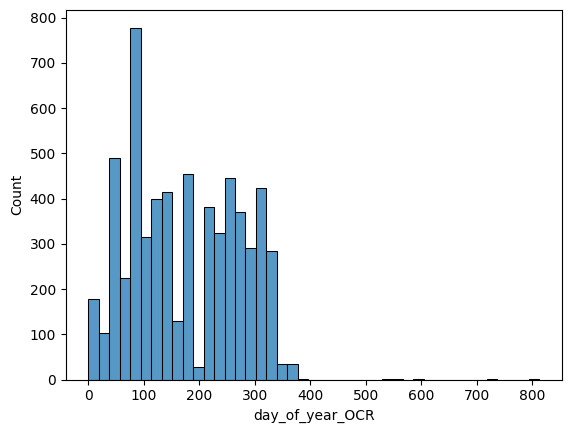

In [128]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].astype('float')
sns.histplot(data=df_num2, x='day_of_year_OCR')

In [129]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x>366 else x)
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x==0 else x)
df_num2['day_of_year'] = df_num2['day_of_year_OCR']
df_num2[['day_of_year', 'day_of_year_OCR']].sample(10)

,day_of_year,day_of_year_OCR
19482,328.0,328.0
19958,55.0,55.0
23715,136.0,136.0
9532,210.0,210.0
3996,294.0,294.0
19529,318.0,318.0
24296,175.0,175.0
3203,215.0,215.0
9357,216.0,216.0
16523,174.0,174.0


hour:

<Axes: xlabel='hour_OCR', ylabel='Count'>

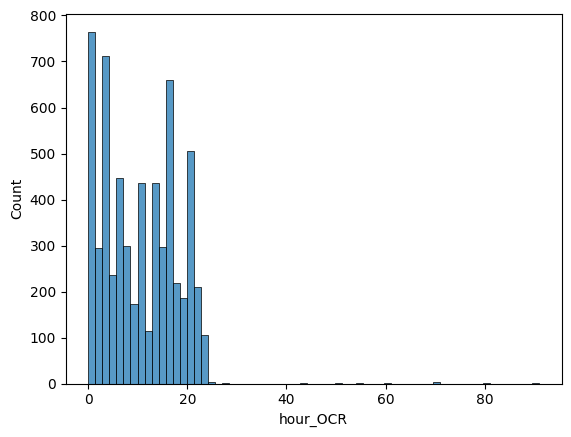

In [130]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].astype('float')
sns.histplot(data=df_num2, x='hour_OCR')

In [131]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].apply(lambda x: np.nan if x>24 else x)
df_num2['hour'] = df_num2['hour_OCR']
df_num2[['hour', 'hour_OCR']].sample(10)

,hour,hour_OCR
19247,11.0,11.0
20646,22.0,22.0
16285,15.0,15.0
9073,16.0,16.0
23401,16.0,16.0
18017,6.0,6.0
15416,NaN,NaN
4027,14.0,14.0
9410,20.0,20.0
16281,15.0,15.0


minute:

<Axes: xlabel='minute_OCR', ylabel='Count'>

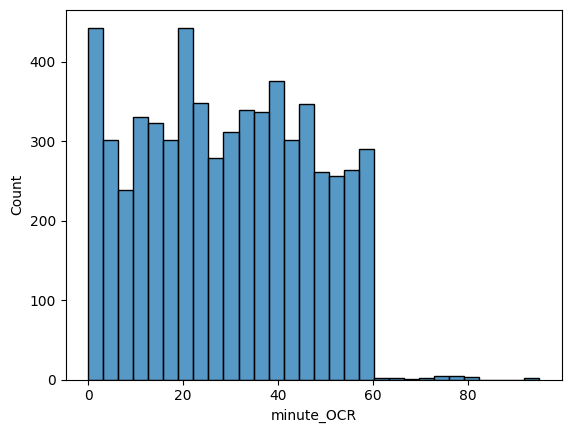

In [132]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].astype('float')
sns.histplot(data=df_num2, x='minute_OCR')

In [133]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['minute'] = df_num2['minute_OCR']
df_num2[['minute', 'minute_OCR']].sample(10)

,minute,minute_OCR
22133,52.0,52.0
15983,3.0,3.0
25746,58.0,58.0
23262,12.0,12.0
18577,45.0,45.0
19813,34.0,34.0
22559,3.0,3.0
21737,6.0,6.0
19589,15.0,15.0
26518,45.0,45.0


second:

<Axes: xlabel='second_OCR', ylabel='Count'>

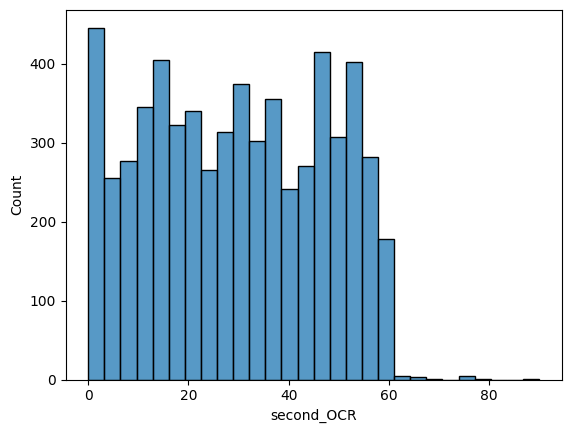

In [134]:
df_num2['second_OCR'] = df_num2['second_OCR'].astype('float')
sns.histplot(data=df_num2, x='second_OCR')

In [135]:
df_num2['second_OCR'] = df_num2['second_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['second'] = df_num2['second_OCR']
df_num2[['second', 'second_OCR']].sample(10)

,second,second_OCR
21778,30.0,30.0
19446,20.0,20.0
16887,35.0,35.0
20081,51.0,51.0
4078,4.0,4.0
9431,28.0,28.0
21736,11.0,11.0
16878,26.0,26.0
21993,6.0,6.0
23080,48.0,48.0


construct timestamp:

In [136]:
df_num2 = construct_timestamp(df_in=df_num2)
print(len(df_num2))

6111


In [137]:
df_num2[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
23659,NaN,05,15,11.0,15.0,10.0,NaT,0
9176,1967.0,07,31,20.0,33.0,49.0,1967-07-31 20:33:49,1
21781,1967.0,03,24,2.0,0.0,22.0,1967-03-24 02:00:22,1
26605,1967.0,11,06,10.0,43.0,19.0,1967-11-06 10:43:19,1
26328,1967.0,07,30,4.0,34.0,53.0,1967-07-30 04:34:53,1
22178,1967.0,04,27,21.0,16.0,54.0,1967-04-27 21:16:54,1
23652,1967.0,05,15,11.0,13.0,26.0,1967-05-15 11:13:26,1
22317,1968.0,06,28,13.0,33.0,35.0,1968-06-28 13:33:35,1
26365,1967.0,09,29,3.0,23.0,44.0,1967-09-29 03:23:44,1
16699,1967.0,06,16,8.0,15.0,46.0,1967-06-16 08:15:46,1


#  

#### num - check timestamp components, construct timestamp:

In [138]:
df_num[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2
37787,0.0,2.0,7.0,0.0,3.0,2.0,9.0,5.0,0.0,0.0
31967,4.0,2.0,5.0,6.0,1.0,1.0,9.0,0.0,7.0,2.0
39361,4.0,0.0,5.0,3.0,0.0,0.0,1.0,5.0,5.0,3.0
40341,3.0,2.0,1.0,5.0,0.0,2.0,1.0,4.0,5.0,2.0
33582,0.0,5.0,5.0,0.0,5.0,4.0,6.0,0.0,5.0,0.0
31786,4.0,2.0,1.0,5.0,1.0,2.0,3.0,9.0,0.0,3.0
33895,5.0,0.0,8.0,8.0,1.0,7.0,3.0,0.0,5.0,8.0
31246,1.0,6.0,5.0,1.0,0.0,0.0,9.0,2.0,7.0,0.0
39135,4.0,0.0,5.0,3.0,0.0,3.0,5.0,7.0,0.0,4.0
32887,4.0,2.0,7.0,7.0,1.0,8.0,0.0,8.0,3.0,3.0


year - adjust to baseline 1962:

<Axes: xlabel='year', ylabel='Count'>

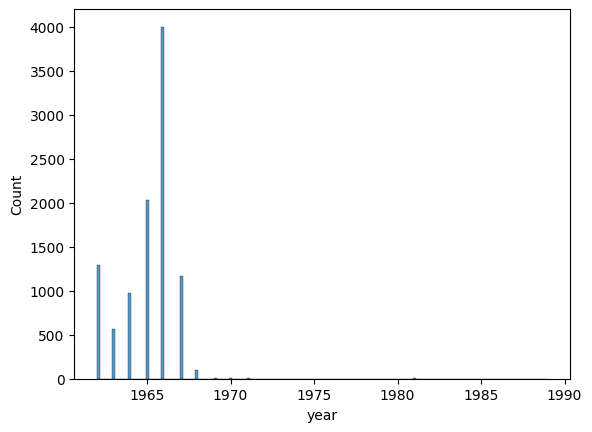

In [139]:
df_num = df_num.copy(deep=True)
df_num['year'] = df_num['year_1'] + 1962
df_num['year'] = df_num['year'].astype('float')
sns.histplot(data=df_num, x='year')

In [140]:
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x<1962 else x)
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x>1980 else x)
df_num[['year', 'year_1']].sample(10)

,year,year_1
34281,1966.0,4.0
39908,1966.0,4.0
32454,1964.0,2.0
40748,1965.0,3.0
35966,1965.0,3.0
41423,1965.0,3.0
37729,1962.0,0.0
41375,1965.0,3.0
24923,1964.0,2.0
34916,1967.0,5.0


day:

<Axes: xlabel='day_1', ylabel='Count'>

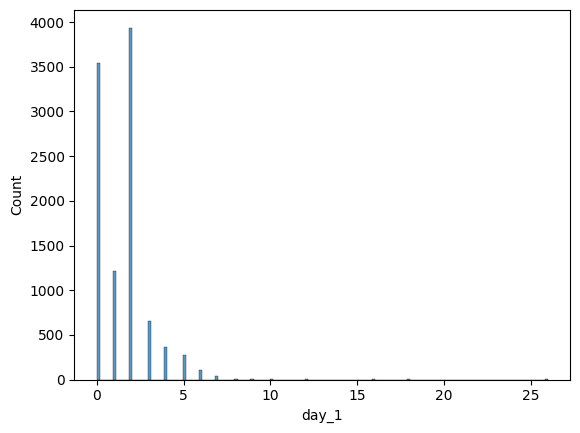

In [141]:
df_num['day_1'] = df_num['day_1'].astype(int)
sns.histplot(data=df_num, x='day_1')

In [142]:
df_num['day_1'] = df_num['day_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_2', ylabel='Count'>

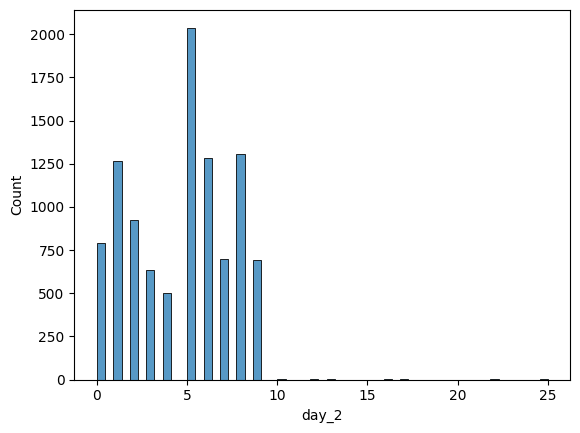

In [143]:
df_num['day_2'] = df_num['day_2'].astype(int)
sns.histplot(data=df_num, x='day_2')

In [144]:
df_num['day_2'] = df_num['day_2'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_3', ylabel='Count'>

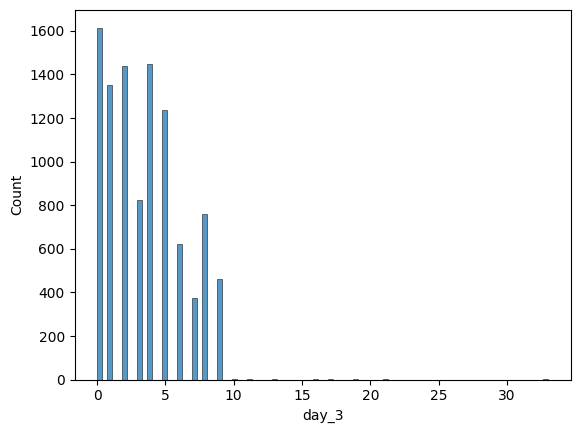

In [145]:
df_num['day_3'] = df_num['day_3'].astype(int)
sns.histplot(data=df_num, x='day_3')

In [146]:
df_num['day_3'] = df_num['day_3'].apply(lambda x: np.nan if x>9 else x)

In [147]:
df_num_daycheck = df_num[~pd.isna(df_num['day_1'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_2'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_3'])]
df_num_daycheck['day_of_year'] = df_num_daycheck['day_1'].astype(int).astype(str) + df_num_daycheck['day_2'].astype(int).astype(str) + df_num_daycheck['day_3'].astype(int).astype(str)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].astype(int)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_num_nullday = df_num.loc[pd.isna(df_num['day_1']) | pd.isna(df_num['day_2']) | pd.isna(df_num['day_3'])]
df_num_nullday = df_num_nullday.copy(deep=True)
df_num_nullday['day_of_year'] = np.nan
df_num = pd.concat([df_num_daycheck, df_num_nullday])
print(len(df_num))
df_num[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

10150


,day_of_year,day_1,day_2,day_3
25063,111.0,1.0,1.0,1.0
31248,166.0,1.0,6.0,6.0
34920,NaN,5.0,4.0,2.0
34552,251.0,2.0,5.0,1.0
37456,11.0,0.0,1.0,1.0
2633,221.0,2.0,2.0,1.0
34160,49.0,0.0,4.0,9.0
31724,214.0,2.0,1.0,4.0
33473,37.0,0.0,3.0,7.0
35360,NaN,4.0,1.0,4.0


hour:

<Axes: xlabel='hour_1', ylabel='Count'>

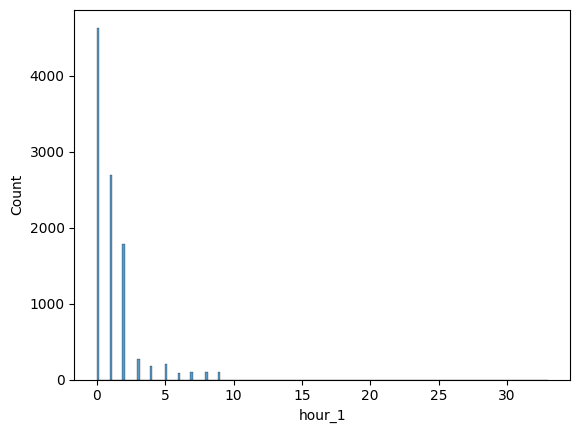

In [148]:
df_num['hour_1'] = df_num['hour_1'].astype(int)
sns.histplot(data=df_num, x='hour_1')

In [149]:
df_num['hour_1'] = df_num['hour_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='hour_2', ylabel='Count'>

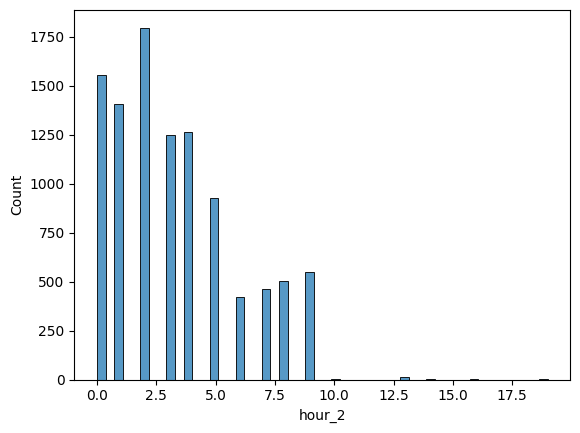

In [150]:
df_num['hour_2'] = df_num['hour_2'].astype(int)
sns.histplot(data=df_num, x='hour_2')

In [151]:
df_num['hour_2'] = df_num['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [152]:
df_num_hourcheck = df_num[~pd.isna(df_num['hour_1'])]
df_num_hourcheck = df_num_hourcheck[~pd.isna(df_num_hourcheck['hour_2'])]
df_num_hourcheck['hour'] = df_num_hourcheck['hour_1'].astype(int).astype(str) + df_num_hourcheck['hour_2'].astype(int).astype(str)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].astype(int)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_num_nullhour = df_num.loc[pd.isna(df_num['hour_1']) | pd.isna(df_num['hour_2'])]
df_num_nullhour = df_num_nullhour.copy(deep=True)
df_num_nullhour['hour'] = np.nan
df_num = pd.concat([df_num_hourcheck, df_num_nullhour])
print(len(df_num))
df_num[['hour', 'hour_1', 'hour_2']].sample(10)

10150


,hour,hour_1,hour_2
12289,22.0,2.0,2.0
34146,5.0,0.0,5.0
32644,1.0,0.0,1.0
37703,14.0,1.0,4.0
33414,NaN,3.0,0.0
34433,17.0,1.0,7.0
34000,12.0,1.0,2.0
39665,5.0,0.0,5.0
12423,4.0,0.0,4.0
32658,4.0,0.0,4.0


minute:

<Axes: xlabel='minute_1', ylabel='Count'>

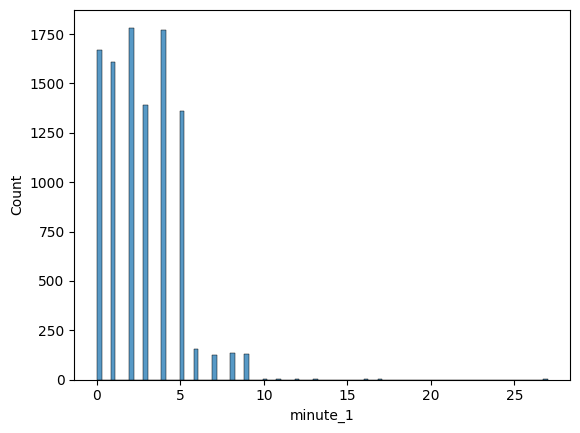

In [153]:
df_num['minute_1'] = df_num['minute_1'].astype(int)
sns.histplot(data=df_num, x='minute_1')

In [154]:
df_num['minute_1'] = df_num['minute_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='minute_2', ylabel='Count'>

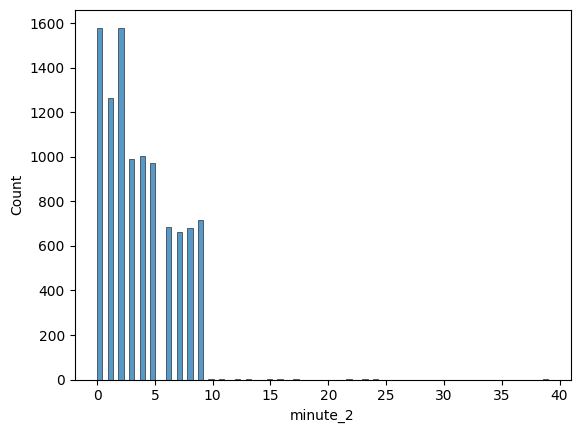

In [155]:
df_num['minute_2'] = df_num['minute_2'].astype(int)
sns.histplot(data=df_num, x='minute_2')

In [156]:
df_num['minute_2'] = df_num['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [157]:
df_num_mincheck = df_num[~pd.isna(df_num['minute_1'])]
df_num_mincheck = df_num_mincheck[~pd.isna(df_num_mincheck['minute_2'])]
df_num_mincheck['minute'] = df_num_mincheck['minute_1'].astype(int).astype(str) + df_num_mincheck['minute_2'].astype(int).astype(str)
df_num_mincheck['minute'] = df_num_mincheck['minute'].astype(int)
df_num_mincheck['minute'] = df_num_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_num_nullmin = df_num.loc[pd.isna(df_num['minute_1']) | pd.isna(df_num['minute_2'])]
df_num_nullmin = df_num_nullmin.copy(deep=True)
df_num_nullmin['minute'] = np.nan
df_num = pd.concat([df_num_mincheck, df_num_nullmin])
print(len(df_num))
df_num[['minute', 'minute_1', 'minute_2']].sample(10)

10150


,minute,minute_1,minute_2
32804,51.0,5.0,1.0
31059,3.0,0.0,3.0
34908,51.0,5.0,1.0
33129,20.0,2.0,0.0
32962,30.0,3.0,0.0
31764,46.0,4.0,6.0
33630,37.0,3.0,7.0
32910,14.0,1.0,4.0
40518,34.0,3.0,4.0
33085,11.0,1.0,1.0


second:

<Axes: xlabel='second_1', ylabel='Count'>

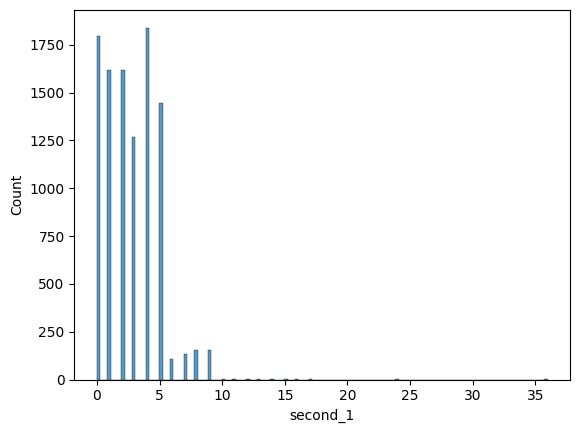

In [158]:
df_num['second_1'] = df_num['second_1'].astype(int)
sns.histplot(data=df_num, x='second_1')

In [159]:
df_num['second_1'] = df_num['second_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='second_2', ylabel='Count'>

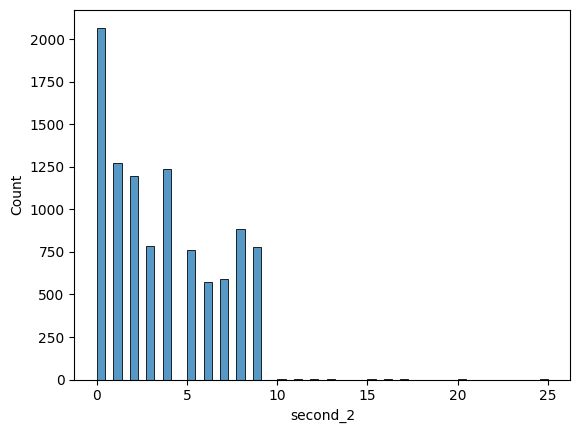

In [160]:
df_num['second_2'] = df_num['second_2'].astype(int)
sns.histplot(data=df_num, x='second_2')

In [161]:
df_num['second_2'] = df_num['second_2'].apply(lambda x: np.nan if x>9 else x)

In [162]:
df_num_seccheck = df_num[~pd.isna(df_num['second_1'])]
df_num_seccheck = df_num_seccheck[~pd.isna(df_num_seccheck['second_2'])]
df_num_seccheck['second'] = df_num_seccheck['second_1'].astype(int).astype(str) + df_num_seccheck['second_2'].astype(int).astype(str)
df_num_seccheck['second'] = df_num_seccheck['second'].astype(int)
df_num_seccheck['second'] = df_num_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_num_nullsec = df_num.loc[pd.isna(df_num['second_1']) | pd.isna(df_num['second_2'])]
df_num_nullsec = df_num_nullsec.copy(deep=True)
df_num_nullsec['second'] = np.nan
df_num = pd.concat([df_num_seccheck, df_num_nullsec])
print(len(df_num))
df_num[['second', 'second_1', 'second_2']].sample(10)

10150


,second,second_1,second_2
33547,10.0,1.0,0.0
34657,43.0,4.0,3.0
12089,42.0,4.0,2.0
2532,22.0,2.0,2.0
34780,48.0,4.0,8.0
38182,42.0,4.0,2.0
37391,3.0,0.0,3.0
31736,51.0,5.0,1.0
35364,NaN,7.0,2.0
35358,37.0,3.0,7.0


construct timestamp:

In [163]:
df_num = construct_timestamp(df_in=df_num)
print(len(df_num))

10150


In [164]:
df_num[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
32444,1964.0,NaN,NaN,NaN,11.0,NaN,NaT,0
41889,1967.0,08,21,NaN,40.0,NaN,1967-08-21 00:00:00,4
37561,1962.0,04,11,22.0,43.0,0.0,1962-04-11 22:43:00,1
33903,1967.0,03,29,17.0,32.0,57.0,1967-03-29 17:32:57,1
34773,1966.0,10,01,12.0,49.0,43.0,1966-10-01 12:49:43,1
33321,1962.0,12,17,10.0,41.0,0.0,1962-12-17 10:41:00,1
36674,1965.0,10,17,4.0,5.0,28.0,1965-10-17 04:05:28,1
30654,1966.0,05,18,5.0,32.0,47.0,1966-05-18 05:32:47,1
33389,1967.0,02,04,13.0,56.0,NaN,1967-02-04 13:56:00,2
34771,1966.0,08,22,12.0,48.0,48.0,1966-08-22 12:48:48,1


#  

#### dot - check timestamp components, construct timestamp:

In [165]:
df_dot = df_dot.copy(deep=True)
df_dot[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'is_dot']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2,is_dot
36488,NaN,1.0,8.0,8.0,8.0,9.0,1.0,0.0,25.0,0.0,NaN
37116,NaN,1.0,8.0,0.0,9.0,8.0,8.0,1.0,9.0,8.0,NaN
36473,NaN,1.0,8.0,8.0,9.0,16.0,1.0,0.0,1.0,1.0,NaN
35687,NaN,1.0,16.0,8.0,9.0,8.0,8.0,8.0,9.0,0.0,NaN
35626,NaN,1.0,8.0,0.0,9.0,8.0,0.0,1.0,8.0,8.0,NaN
36417,NaN,1.0,8.0,8.0,8.0,8.0,9.0,8.0,9.0,0.0,NaN
35525,NaN,1.0,8.0,8.0,16.0,0.0,9.0,9.0,9.0,0.0,NaN
37153,NaN,1.0,8.0,0.0,18.0,8.0,8.0,0.0,8.0,1.0,NaN
36359,NaN,1.0,8.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,NaN
32150,NaN,8.0,0.0,0.0,1.0,8.0,8.0,0.0,1.0,8.0,NaN


day:

<Axes: xlabel='day_1', ylabel='Count'>

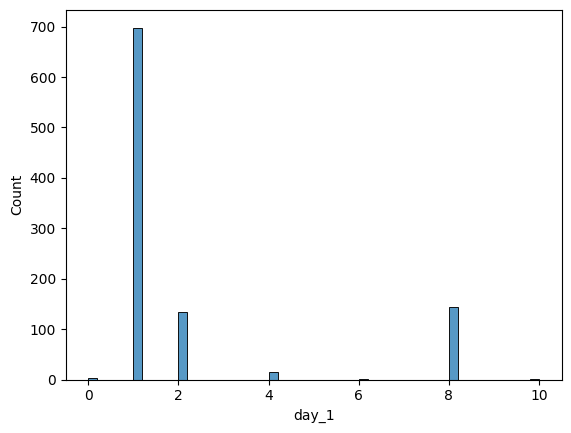

In [166]:
df_dot['day_1'] = df_dot['day_1'].astype(int)
sns.histplot(data=df_dot, x='day_1')

In [167]:
df_dot['day_1'] = df_dot['day_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_2', ylabel='Count'>

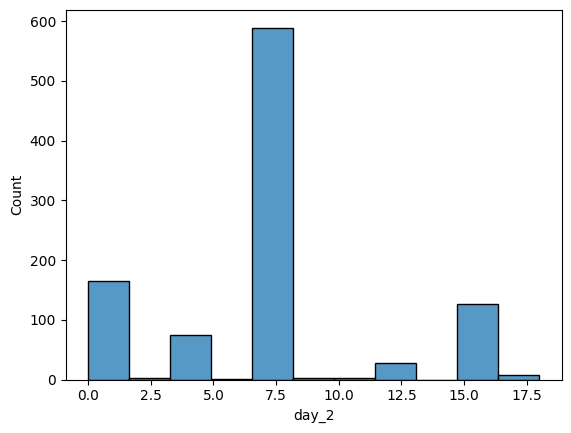

In [168]:
df_dot['day_2'] = df_dot['day_2'].astype(int)
sns.histplot(data=df_dot, x='day_2')

In [169]:
df_dot['day_2'] = df_dot['day_2'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_3', ylabel='Count'>

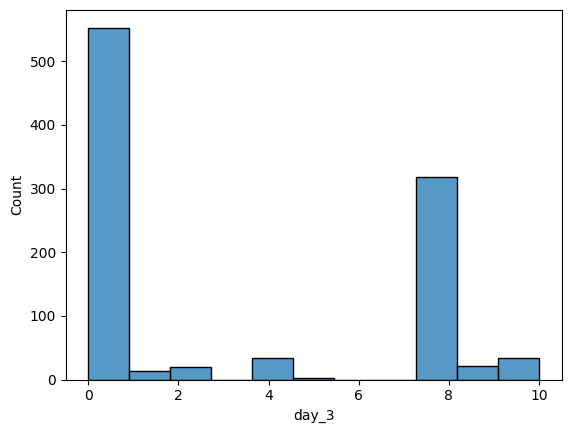

In [170]:
df_dot['day_3'] = df_dot['day_3'].astype(int)
sns.histplot(data=df_dot, x='day_3')

In [171]:
df_dot['day_3'] = df_dot['day_3'].apply(lambda x: np.nan if x>9 else x)

In [172]:
df_dot_daycheck = df_dot[~pd.isna(df_dot['day_1'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_2'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_3'])]
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_1'].astype(int).astype(str) + df_dot_daycheck['day_2'].astype(int).astype(str) + df_dot_daycheck['day_3'].astype(int).astype(str)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].astype(int)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_dot_nullday = df_dot.loc[pd.isna(df_dot['day_1']) | pd.isna(df_dot['day_2']) | pd.isna(df_dot['day_3'])]
df_dot_nullday = df_dot_nullday.copy(deep=True)
df_dot_nullday['day_of_year'] = np.nan
df_dot = pd.concat([df_dot_daycheck, df_dot_nullday])
print(len(df_dot))
df_dot[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

997


,day_of_year,day_1,day_2,day_3
36522,180.0,1.0,8.0,0.0
32352,189.0,1.0,8.0,9.0
35710,288.0,2.0,8.0,8.0
32182,NaN,8.0,0.0,0.0
35500,140.0,1.0,4.0,0.0
32304,NaN,8.0,0.0,0.0
35569,140.0,1.0,4.0,0.0
36471,188.0,1.0,8.0,8.0
32310,NaN,8.0,0.0,0.0
32265,NaN,8.0,0.0,0.0


year - infer from day:

In [173]:
df_dot['year'] = np.nan
for i in range(0, len(df_dot)):
    day = df_dot['day_of_year'].iloc[i]
    if (day < 366) & (day > 0):
        if day > 271:
            df_dot['year'].iloc[i] = 1962
        else:
            df_dot['year'].iloc[i] = 1963
df_dot[['year', 'day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

C:\Users\rnaidoo\AppData\Local\Temp\ipykernel_24036\2722169012.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dot['year'].iloc[i] = 1962
C:\Users\rnaidoo\AppData\Local\Temp\ipykernel_24036\2722169012.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dot['year'].iloc[i] = 1963


,year,day_of_year,day_1,day_2,day_3
35769,NaN,NaN,1.0,NaN,8.0
37096,1963.0,191.0,1.0,9.0,1.0
36433,NaN,NaN,1.0,NaN,8.0
36420,1963.0,188.0,1.0,8.0,8.0
36469,1963.0,188.0,1.0,8.0,8.0
32175,NaN,NaN,2.0,8.0,NaN
37123,1962.0,288.0,2.0,8.0,8.0
36382,1963.0,188.0,1.0,8.0,8.0
36514,NaN,NaN,1.0,NaN,8.0
36305,1963.0,188.0,1.0,8.0,8.0


hour:

<Axes: xlabel='hour_1', ylabel='Count'>

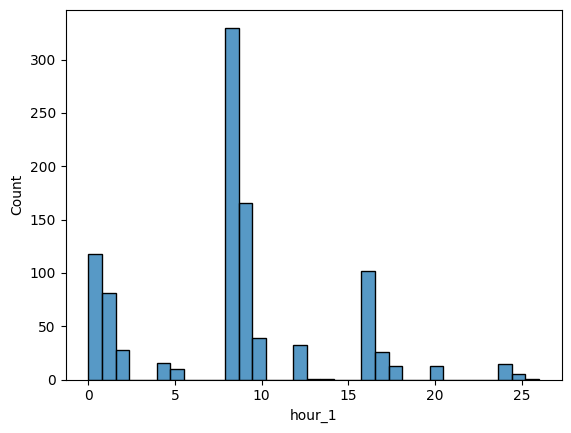

In [174]:
df_dot['hour_1'] = df_dot['hour_1'].astype(int)
sns.histplot(data=df_dot, x='hour_1')

In [175]:
df_dot['hour_1'] = df_dot['hour_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='hour_2', ylabel='Count'>

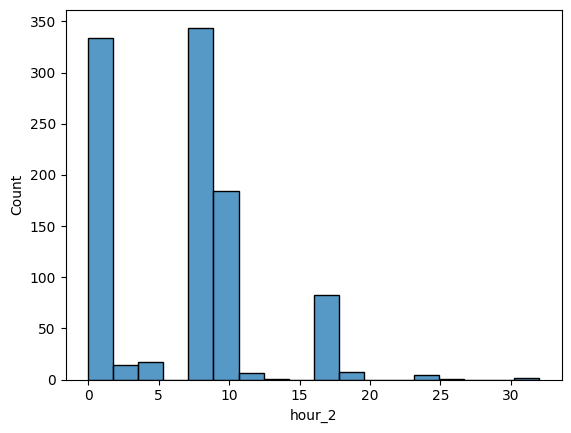

In [176]:
df_dot['hour_2'] = df_dot['hour_2'].astype(int)
sns.histplot(data=df_dot, x='hour_2')

In [177]:
df_dot['hour_2'] = df_dot['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [178]:
df_dot_hourcheck = df_dot[~pd.isna(df_dot['hour_1'])]
df_dot_hourcheck = df_dot_hourcheck[~pd.isna(df_dot_hourcheck['hour_2'])]
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour_1'].astype(int).astype(str) + df_dot_hourcheck['hour_2'].astype(int).astype(str)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].astype(int)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_dot_nullhour = df_dot.loc[pd.isna(df_dot['hour_1']) | pd.isna(df_dot['hour_2'])]
df_dot_nullhour = df_dot_nullhour.copy(deep=True)
df_dot_nullhour['hour'] = np.nan
df_dot = pd.concat([df_dot_hourcheck, df_dot_nullhour])
print(len(df_dot))
df_dot[['hour', 'hour_1', 'hour_2']].sample(10)

997


,hour,hour_1,hour_2
35640,18.0,1.0,8.0
36456,8.0,0.0,8.0
35584,NaN,8.0,0.0
32271,NaN,NaN,2.0
32335,1.0,0.0,1.0
35575,NaN,8.0,0.0
35801,NaN,8.0,8.0
32285,1.0,0.0,1.0
35784,NaN,NaN,0.0
32346,9.0,0.0,9.0


minute:

<Axes: xlabel='minute_1', ylabel='Count'>

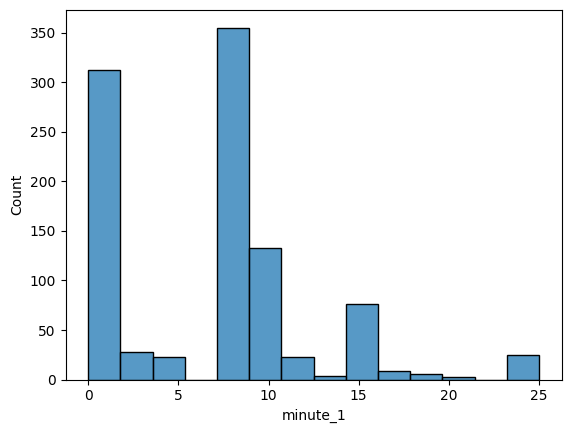

In [179]:
df_dot['minute_1'] = df_dot['minute_1'].astype(int)
sns.histplot(data=df_dot, x='minute_1')

In [180]:
df_dot['minute_1'] = df_dot['minute_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='minute_2', ylabel='Count'>

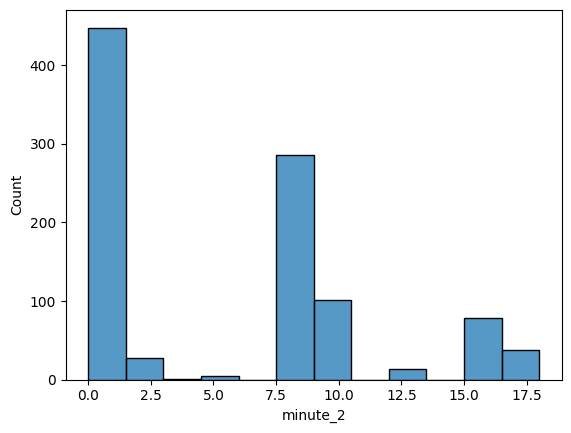

In [181]:
df_dot['minute_2'] = df_dot['minute_2'].astype(int)
sns.histplot(data=df_dot, x='minute_2')

In [182]:
df_dot['minute_2'] = df_dot['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [183]:
df_dot_mincheck = df_dot[~pd.isna(df_dot['minute_1'])]
df_dot_mincheck = df_dot_mincheck[~pd.isna(df_dot_mincheck['minute_2'])]
df_dot_mincheck['minute'] = df_dot_mincheck['minute_1'].astype(int).astype(str) + df_dot_mincheck['minute_2'].astype(int).astype(str)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].astype(int)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullmin = df_dot.loc[pd.isna(df_dot['minute_1']) | pd.isna(df_dot['minute_2'])]
df_dot_nullmin = df_dot_nullmin.copy(deep=True)
df_dot_nullmin['minute'] = np.nan
df_dot = pd.concat([df_dot_mincheck, df_dot_nullmin])
print(len(df_dot))
df_dot[['minute', 'minute_1', 'minute_2']].sample(10)

997


,minute,minute_1,minute_2
32255,NaN,8.0,2.0
35637,40.0,4.0,0.0
35549,NaN,NaN,8.0
35676,0.0,0.0,0.0
32301,NaN,8.0,8.0
36536,NaN,NaN,1.0
32359,NaN,8.0,0.0
36304,0.0,0.0,0.0
37029,NaN,NaN,8.0
36350,NaN,8.0,8.0


second:

<Axes: xlabel='second_1', ylabel='Count'>

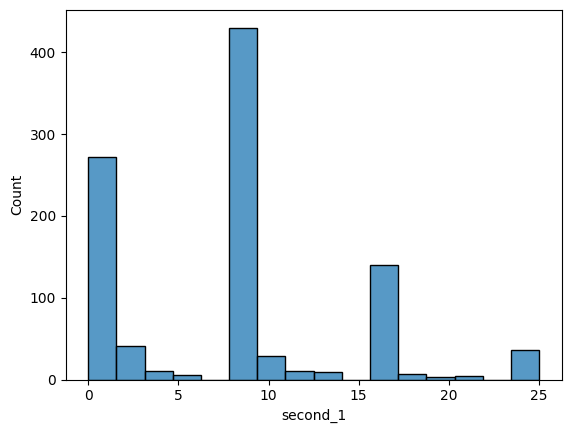

In [184]:
df_dot['second_1'] = df_dot['second_1'].astype(int)
sns.histplot(data=df_dot, x='second_1')

In [185]:
df_dot['second_1'] = df_dot['second_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='second_2', ylabel='Count'>

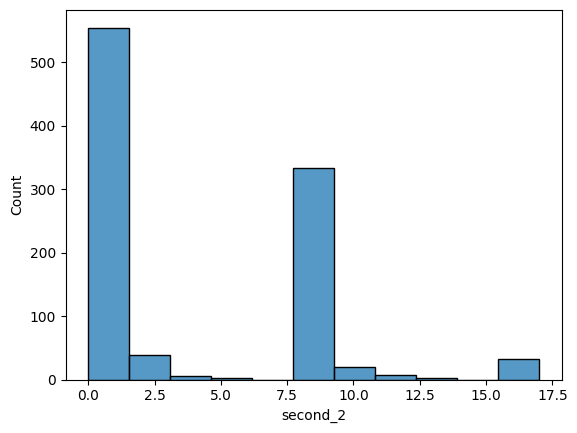

In [186]:
df_dot['second_2'] = df_dot['second_2'].astype(int)
sns.histplot(data=df_dot, x='second_2')

In [187]:
df_dot['second_2'] = df_dot['second_2'].apply(lambda x: np.nan if x>9 else x)

In [188]:
df_dot_seccheck = df_dot[~pd.isna(df_dot['second_1'])]
df_dot_seccheck = df_dot_seccheck[~pd.isna(df_dot_seccheck['second_2'])]
df_dot_seccheck['second'] = df_dot_seccheck['second_1'].astype(int).astype(str) + df_dot_seccheck['second_2'].astype(int).astype(str)
df_dot_seccheck['second'] = df_dot_seccheck['second'].astype(int)
df_dot_seccheck['second'] = df_dot_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullsec = df_dot.loc[pd.isna(df_dot['second_1']) | pd.isna(df_dot['second_2'])]
df_dot_nullsec = df_dot_nullsec.copy(deep=True)
df_dot_nullsec['second'] = np.nan
df_dot = pd.concat([df_dot_seccheck, df_dot_nullsec])
print(len(df_dot))
df_dot[['second', 'second_1', 'second_2']].sample(10)

997


,second,second_1,second_2
35808,NaN,NaN,8.0
32132,19.0,1.0,9.0
36395,8.0,0.0,8.0
37036,NaN,4.0,NaN
37139,NaN,8.0,8.0
36381,8.0,0.0,8.0
32272,NaN,8.0,0.0
36436,NaN,8.0,1.0
35608,58.0,5.0,8.0
36524,NaN,NaN,1.0


construct timestamp:

In [189]:
df_dot = construct_timestamp(df_in=df_dot)
print(len(df_dot))

997


In [190]:
df_dot[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
36400,NaN,NaN,NaN,NaN,NaN,11.0,NaT,0
37062,1963.0,06,29,NaN,NaN,NaN,1963-06-29,4
32160,NaN,NaN,NaN,NaN,0.0,NaN,NaT,0
35687,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
35605,1963.0,06,29,NaN,1.0,NaN,1963-06-29,4
36425,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
35665,NaN,NaN,NaN,NaN,NaN,18.0,NaT,0
36434,NaN,NaN,NaN,NaN,9.0,19.0,NaT,0
32317,NaN,NaN,NaN,NaN,0.0,19.0,NaT,0
32355,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0


#  

#### Check station number:

num2:

<Axes: xlabel='station_number_OCR', ylabel='Count'>

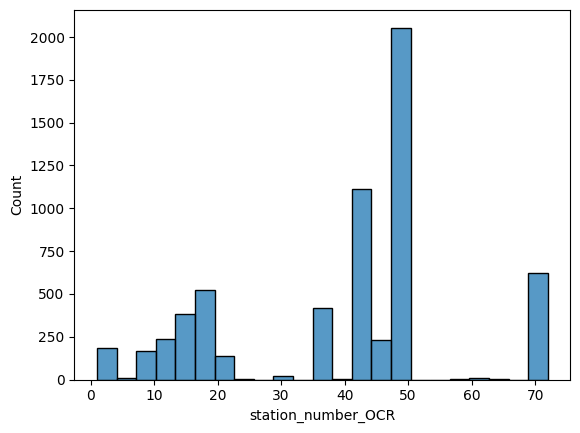

In [191]:
df_num2['station_number_OCR'] = df_num2['station_number_OCR'].astype('float')
sns.histplot(data=df_num2, x='station_number_OCR')

In [192]:
df_num2['station_number'] = df_num2['station_number_OCR']
df_num2[['station_number', 'station_number_OCR']].sample(10)

,station_number,station_number_OCR
21014,43.0,43.0
16069,21.0,21.0
9554,43.0,43.0
21479,43.0,43.0
23800,50.0,50.0
20337,72.0,72.0
28976,43.0,43.0
18521,43.0,43.0
17063,8.0,8.0
26735,50.0,50.0


num:

<Axes: xlabel='station_number_1', ylabel='Count'>

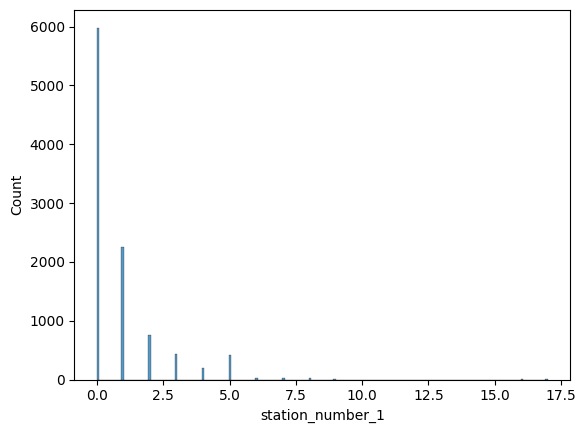

In [193]:
df_num['station_number_1'] = df_num['station_number_1'].astype(int)
sns.histplot(data=df_num, x='station_number_1')

In [194]:
df_num['station_number_1'] = df_num['station_number_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='station_number_2', ylabel='Count'>

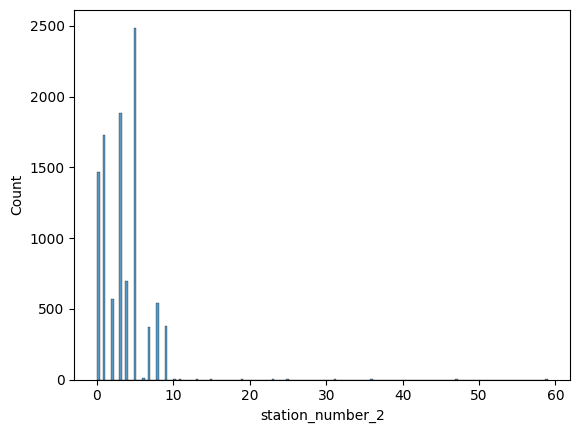

In [195]:
df_num['station_number_2'] = df_num['station_number_2'].astype(int)
sns.histplot(data=df_num, x='station_number_2')

In [196]:
df_num['station_number_2'] = df_num['station_number_2'].apply(lambda x: np.nan if x>9 else x)

In [197]:
df_num_stncheck = df_num[~pd.isna(df_num['station_number_1'])]
df_num_stncheck = df_num_stncheck[~pd.isna(df_num_stncheck['station_number_2'])]
df_num_stncheck['station_number'] = df_num_stncheck['station_number_1'].astype(int).astype(str) + df_num_stncheck['station_number_2'].astype(int).astype(str)
df_num_stncheck['station_number'] = df_num_stncheck['station_number'].astype(int)
df_num_nullstn = df_num.loc[pd.isna(df_num['station_number_1']) | pd.isna(df_num['station_number_2'])]
df_num_nullstn = df_num_nullstn.copy(deep=True)
df_num_nullstn['station_number'] = np.nan
df_num = pd.concat([df_num_stncheck, df_num_nullstn])
print(len(df_num))
df_num[['station_number', 'station_number_1', 'station_number_2']].sample(10)

10150


,station_number,station_number_1,station_number_2
33905,3.0,0.0,3.0
36227,9.0,0.0,9.0
38640,5.0,0.0,5.0
37556,10.0,1.0,0.0
34176,50.0,5.0,0.0
34393,8.0,0.0,8.0
34049,50.0,5.0,0.0
33286,50.0,5.0,0.0
30643,18.0,1.0,8.0
37548,1.0,0.0,1.0


dot:

In [198]:
df_dot[['station_number']].sample(10)

,station_number
37015,22.0
35755,9.0
36381,32.0
35785,1.0
32297,1.0
37075,18.0
37111,5.0
36363,16.0
36285,16.0
32307,1.0


#  

#### Recombine results:

In [199]:
df_result2 = pd.concat([df_num2, df_num, df_dot, df_outlier, df_loss])
print(len(df_result2))
df_result2.sample(10)

42466


,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,year,day_of_year,hour,minute,second,time_quality,month_day,month,day,Timestamp
14516,R014207827,3809-38A,94.png,loss,1.596774,3220.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
36720,R014207961,1077-B,192.png,num,1.500000,907.692308,7.0,0.0,7.0,3.0,...,1965.0,292.0,1.0,32.0,6.0,1.0,10-19,10,19,1965-10-19 01:32:06
20954,R014207834,4491-43A,251.png,num2,1.645161,1378.431373,43.0,NaN,NaN,NaN,...,1968.0,87.0,16.0,11.0,48.0,1.0,03-28,03,28,1968-03-28 16:11:48
37502,R014207963,1509-1B,263.png,num,1.500000,1392.000000,1.0,0.0,1.0,4.0,...,1966.0,11.0,11.0,17.0,53.0,1.0,01-11,01,11,1966-01-11 11:17:53
2817,R014207808,4581-19,179.png,num2,1.584677,1331.250000,19.0,NaN,NaN,NaN,...,1966.0,185.0,18.0,56.0,3.0,1.0,07-04,07,04,1966-07-04 18:56:03
39060,R014207963,1544-1B,1.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
20558,R014207834,4479-72,123.png,num2,1.500000,1596.875000,72.0,NaN,NaN,NaN,...,1968.0,105.0,9.0,30.0,57.0,1.0,04-15,04,15,1968-04-15 09:30:57
5311,R014207810,5134,93.png,loss,3.354545,509.090909,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
32520,R014207944,2027-13B,190.png,num,1.500000,1240.384615,30.0,3.0,0.0,2.0,...,1964.0,NaN,NaN,14.0,21.0,0.0,NaN,NaN,NaN,NaT
589,R014207711,39,101.png,num,8.871951,883.950617,13.0,1.0,3.0,2.0,...,1964.0,120.0,2.0,20.0,30.0,1.0,04-30,04,30,1964-04-30 02:20:30


Classify unread station number as loss:

In [ ]:
df_result2.loc[pd.isna(df_result2['station_number'])]

In [ ]:
df_merge.loc[df_merge[col].str.contains("[a-zA-Z]"), 'processed_image_class'] = 'loss'
df_merge.loc[df_merge[col].str.contains("[a-zA-Z]"), 'details'] = 'OCR read metadata contains letters'

#  

#### Retrieve station details:

In [200]:
df_stn_nums = pd.read_excel(logDir + 'station_number_changes.xlsx')
df_stn_nums.head()

,Station_Number,Station_Code,Station_Name,Start_Date,Notes
0,1,RES,"Resolute Bay, NT, Canada",1962-09-29,Assumed start date at launch.
1,1,BPT,"Blossom Point, MD, USA",1965-07-01,NaN
2,2,PRI,"Prince Albert, SK, Canada",1962-09-29,Assumed start date at launch.
3,3,OTT,"Ottawa, Canada",1962-09-29,Assumed start date at launch.
4,3,FTM,"Fort Myers, FL, USA",1965-07-01,NaN


In [201]:
change_dates = df_stn_nums['Start_Date'].drop_duplicates().sort_values().reset_index(drop=True)
stn_nums = df_stn_nums['Station_Number'].unique()

In [202]:
df_result3 = pd.DataFrame()
for i in range(0, len(change_dates)):
    #Before the first change date - Assume there are no station numbers before launch
    if i == 0:
        print(change_dates[i])
        df_part = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))
    
    elif i > 0:
        print(change_dates[i])
        df_part_ = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_part_ = df_part_.loc[df_part_['Timestamp'] >= change_dates[i-1]]
        
        df_sns = pd.DataFrame()
        for sn in stn_nums:
            df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
            df_sn = df_sn.loc[df_sn['Start_Date'] < change_dates[i]]
            if len(df_sn) > 1:
                df_sn = df_sn.sort_values('Start_Date', ascending=False)
                df_sn = df_sn.iloc[:1]
            df_sns = pd.concat([df_sns, df_sn])
        
        df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))

#After last change date
last_change_date = change_dates[len(change_dates)-1]
print('After ' + str(last_change_date))
df_part_ = df_result2.loc[df_result2['Timestamp'] > last_change_date]

df_sns = pd.DataFrame()
for sn in stn_nums:
    df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
    if len(df_sn) > 1:
        df_sn = df_sn.sort_values('Start_Date', ascending=False)
        df_sn = df_sn.iloc[:1]
    df_sns = pd.concat([df_sns, df_sn])

df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
df_result3 = pd.concat([df_result3, df_part])
print(len(df_result3))

1962-09-29 00:00:00
554
1963-04-25 00:00:00
1036
1963-08-06 00:00:00
1655
1965-07-01 00:00:00
2518
After 1965-07-01 00:00:00
14684


In [203]:
df_stns = pd.read_csv(logDir + 'ground_stations.csv')
df_stns.head()

,Station_Code,Station_Name,Lat,Lng,Notes
0,ANT,"Antofagasta, Chile",23.6S,70.3W,NaN
1,BAT,"Byrd Station, Antarctica",80S,119.3W,Ref: https://en.wikipedia.org/wiki/Byrd_Station
2,BFR,"Bretigny, France",48.4N,2.2 E,Ref: https://en.wikipedia.org/wiki/Br%C3%A9tig...
3,BLR,"Boulder, CO, USA",40.1N,105.1W,NaN
4,BPT,"Blossom Point, MD, USA",38.4N,77.1W,NaN


In [204]:
df_result4 = df_result3.merge(df_stns[['Station_Code', 'Station_Name', 'Lat', 'Lng']], how='left', on='Station_Code')
print(len(df_result4))
df_result4[['Station_Number', 'Timestamp', 'Station_Code', 'Station_Name', 'Lat', 'Lng']].sample(10)

14684


,Station_Number,Timestamp,Station_Code,Station_Name,Lat,Lng
13719,5.0,1965-10-15 19:42:00,QUI,"Quito, Ecuador",0.6S,78.6W
14144,13.0,1965-09-24 18:52:56,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
8624,1.0,1966-09-12 03:03:24,BPT,"Blossom Point, MD, USA",38.4N,77.1W
1940,25.0,1964-08-10 22:40:42,TRO,"Tromso, Norway",69.7N,18.9E
2338,5.0,1964-10-30 02:43:55,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
9364,3.0,1967-04-01 02:07:45,FTM,"Fort Myers, FL, USA",26.6N,81.9W
8126,5.0,1966-06-15 18:00:36,QUI,"Quito, Ecuador",0.6S,78.6W
13747,5.0,1965-10-15 21:45:58,QUI,"Quito, Ecuador",0.6S,78.6W
7703,18.0,1966-05-20 14:20:06,WOO,"Woomera, Australia",31.1S,136.8E
5318,NaN,1968-03-16 00:17:48,NaN,NaN,NaN,NaN


#  

#### Save:

In [205]:
df_result5 = df_result4[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 'Timestamp',
                         'time_quality', 'Station_Number', 'Station_Code', 'Station_Name', 'Lat', 'Lng']]
df_result5.sample(10)

,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,Timestamp,time_quality,Station_Number,Station_Code,Station_Name,Lat,Lng
13990,R014207969,1270-5A,88.png,num,1.524194,1450.000000,1965-10-15 05:48:08,1.0,5.0,QUI,"Quito, Ecuador",0.6S,78.6W
13904,R014207969,1270-5A,362.png,num,1.657258,1233.333333,1965-10-16 20:10:08,1.0,5.0,QUI,"Quito, Ecuador",0.6S,78.6W
1058,R014207838,4537-72,125.png,num,1.500000,1434.693878,1963-04-30 21:02:11,1.0,11.0,SNP,Singapore,1.3N,103.8E
7429,R014207843,3237-43A,243.png,num2,1.862903,1054.347826,1966-01-15 11:01:23,1.0,43.0,RES,"Resolute Bay, NT, Canada",74.7N,95W
6038,R014207836,4713-12,76.png,num2,3.915094,1181.395349,1968-12-23 14:35:47,1.0,12.0,NEW,"St. John's, NL, Canada",47.6N,52.4W
3049,R014207818,4212-69-2,108.png,num2,1.500000,1533.333333,1967-07-31 20:26:16,1.0,69.0,TRO,"Tromso, Norway",69.7N,18.9E
13750,R014207969,1270-5A,207.png,num,1.512097,1297.916667,1965-10-15 21:27:06,1.0,5.0,QUI,"Quito, Ecuador",0.6S,78.6W
3864,R014207828,4416-37,114.png,num2,2.040323,898.000000,1968-02-11 03:53:17,1.0,37.0,HAW,"Kauai, HI, USA",22.1N,159.7W
8846,R014207944,2037-13B,229.png,num,1.641129,1286.538462,1966-10-03 17:34:42,1.0,13.0,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
5357,R014207834,4479-72,177.png,num2,1.693548,1050.000000,1968-04-19 19:39:25,1.0,NaN,NaN,NaN,NaN,NaN


In [206]:
df_result5 = df_result5.sort_values('Timestamp').reset_index(drop=True)
df_result5.to_csv(resultDir + 'result_master.csv', index=False)